In [6]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')
from time import time
from munch import munchify
from FKMC.general import shapes 
from FKMC.plotting import spread

from FKMC.general import interaction_matrix, solve_H_vectorised
from FKMC.general import index_histogram_array, sort_IPRs, normalise_IPR, smooth, get_nearby_index,  compute_IPR_and_DOS_histograms, interpolate_IPR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [3]:
def fermi_function(e, beta):
    """
    Define the fermi function with a special path for the 0 temp Beta = inf case.
    """
    if beta == np.inf:
        return e > 0
    return 1 / (1 + np.exp(- beta * e))

No disorder, zero temp fermi function
'
doing defect_density = 0, 
m2 = 0.9999999999999996
fermion_order = [0.88079779]
    


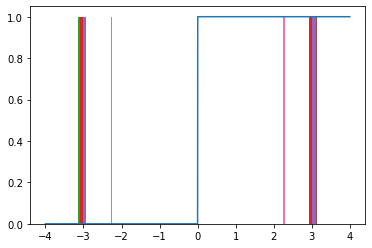

In [92]:
energy_histogram_bins = E_bins = np.linspace(-4, 4, 2000 + 1)

def test1_no_defects(N, beta, U = 5):
    states = (np.arange(N)%2)[None, :]

    
    o = Munch(#T = 2.5 T_i = 1
        E_bins = E_bins,
        parameters = Munch(
                           N = N,
                           beta = np.nan, 
                           U = U,
                           defect_densities = np.linspace(0,0.5,10),
                           mu=0.0, 
                           t = 1,
                           alpha = 1.25,
                           J = 1.0
                          ),
        )
    o.parameters.J_matrix = interaction_matrix(**o.parameters)
    Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **o.parameters)

    A = 2*(np.arange(N) % 2) - 1
    m2 = np.sum(2*(states - 1/2) * A / N)**2

    #The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i]
    # fermion_order = np.sum(fermi_function(eigenvals, beta = np.inf) * (A[:, None] * eigenvecs)) / N

    #f_k psi*_ik O_ij psi_jk
    #k labels energies
    #i,j label sites
    #l labels disorder realisations
    f = fermi_function(eigenvals, beta = beta)
    fermion_order = np.einsum('...k,i,...ik', f, A, np.conj(eigenvecs)*eigenvecs) / N * 2

    
    print(f''''
doing defect_density = 0, 
m2 = {m2}
fermion_order = {fermion_order}
    ''')
    return eigenvals
    
print('No disorder, zero temp fermi function')
eigenvals = test1_no_defects(N =  200, beta = np.inf)
plt.hist(eigenvals)
plt.plot(E_bins, fermi_function(E_bins, beta = np.inf))

'
doing defect_density = 0, 
m2 = 0.9999999999999996
fermion_order = 0.0012499991416676016
    


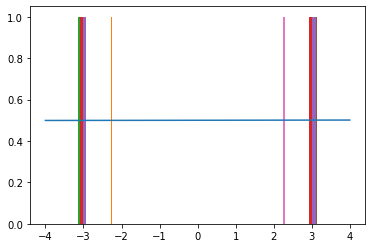

In [57]:
beta = 0.001
eigenvals = test1_no_defects(N =  200, beta = beta)
plt.hist(eigenvals)
plt.plot(E_bins, fermi_function(E_bins, beta = beta))

'
doing defect_density = 0, 
m2 = 0.9999999999999996
fermion_order = 0.12414888302920993
    


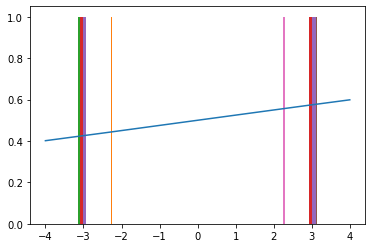

In [61]:
beta = 0.1
eigenvals = test1_no_defects(N =  200, beta = beta)
plt.hist(eigenvals)
plt.plot(E_bins, fermi_function(E_bins, beta = beta))

'
doing defect_density = 0.5, 
m2 = 0.2579640000000002 theory 0.25
fermion_order = 0.43854459422515313
    


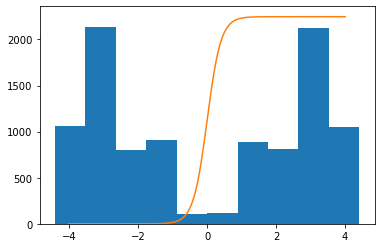

In [93]:
energy_histogram_bins = E_bins = np.linspace(-4, 4, 2000 + 1)
rng = np.random.default_rng()

def test2_with_defects(N, beta, defect_density, M = 100):
    CDW = (np.arange(N)%2)[None, :]
    disorder = rng.choice([1,0], p = [0.5,  0.5], size = (M,N))
    defects = rng.choice([1,0], p = [defect_density, 1-defect_density], size = (M,N))
    states = np.where(defects, disorder, CDW) #choose disorder with probability defect_density

    
    o = Munch(#T = 2.5 T_i = 1
        E_bins = E_bins,
        parameters = Munch(
                           N = N,
                           beta = np.nan, 
                           U = 5,
                           defect_densities = np.linspace(0,0.5,10),
                           mu=0.0, 
                           t = 1,
                           alpha = 1.25,
                           J = 1.0
                          ),
        )
    o.parameters.J_matrix = interaction_matrix(**o.parameters)
    Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **o.parameters)

    A = 2*(np.arange(N) % 2) - 1
    m2 = np.mean(np.sum(2*(states - 1/2) * A[None, :] / N, axis = 0)**2)

    #The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i]
    # fermion_order = np.sum(fermi_function(eigenvals, beta = np.inf) * (A[:, None] * eigenvecs)) / N


    #f_k psi*_ik O_ij psi_jk
    #k labels energies
    #i,j label sites
    #l labels disorder realisations
#     print([np.shape(s) for s in [f, np.conj(eigenvecs), O, eigenvecs]])
    f = fermi_function(eigenvals, beta = beta)
    fermion_order = np.einsum('...k,i,...ik', f, A, np.conj(eigenvecs)*eigenvecs) / N * 2
    fermion_order = np.mean(fermion_order)
    
    print(f''''
doing defect_density = {defect_density}, 
m2 = {m2} theory {(1 - defect_density)**2}
fermion_order = {fermion_order}
    ''')
    return eigenvals
    
beta = 5
eigenvals = test2_with_defects(N = 100, beta = beta, defect_density = 0.5, M = 100)
plt.hist(eigenvals.flatten())
l,h = plt.ylim()
plt.plot(E_bins, h*fermi_function(E_bins, beta = beta))

'
doing defect_density = 0.1, 
m2 = 0.799640000000001 theory 0.81
fermion_order = 1.0000549943238235
    


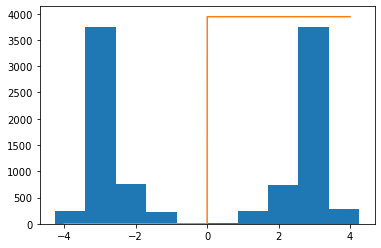

In [49]:
eigenvals = test2_with_defects(N = 100, beta = 0.01, defect_density = 0.1, M = 100)
plt.hist(eigenvals.flatten())
l,h = plt.ylim()
plt.plot(E_bins, h*fermi_function(E_bins, beta = np.inf))

In [ ]:
energy_histogram_bins = E_bins = np.linspace(-4, 4, 2000 + 1)

N_states = int(1e3) # average over N_states // N replications
Ns = np.array([40,  60,  70,  80, 100, 120, 150, 180, 220, 270])
rng = np.random.default_rng()

o = Munch(#T = 2.5 T_i = 1
    E_bins = E_bins,
    parameters = Munch(
                       N = 100,
                       beta = np.nan, 
                       U = 5,
                       defect_densities = np.linspace(0,0.5,10),
                       mu=0.0, 
                       t = 1,
                       alpha = 1.25,
                       J = 1.0
                      ),
    )

K = len(o.parameters.defect_densities)
# o.DOS, o.dDOS, o.IPR, o.dIPR = np.empty((4, K, 2000))

o.Mf_moments = np.empty((K, 6))
o.fermion_order = np.empty(K)

def fermi_function(e, beta):
    return 1 / (1 + np.exp(- beta * e))



for i,defect_density in enumerate(o.parameters.defect_densities):
    M = N_states
    N = o.parameters.N

    CDW = (np.arange(N)%2)[None, :]
    disorder = rng.choice([1,0], p = [0.5,  0.5], size = (M,N))
    defects = rng.choice([1,0], p = [defect_density, 1-defect_density], size = (M,N))
    states = np.where(defects, disorder, CDW) #choose disorder with probability defect_density

    scale = 0.5
    o.parameters.J_matrix = interaction_matrix(**o.parameters)


    #NB the states argument should have only 1s and 0s
    #Fc is infinite at infinite temperature
    Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **o.parameters)
    
    A = 2*(np.arange(N) % 2) - 1
    o.Mf_moments[2, i] = np.sum(2*(states - 1/2) * A[None, :] / N)**2
    #The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i]
    o.fermion_order[i] = np.sum(fermi_function(eigenvals, beta = 5) * (A[:, None] * eigenvecs)) / N

    print(f'doing defect_density = {defect_density}, {o.fermion_order[i]}')

    o.parameters.J_matrix = None

In [ ]:


energy_histogram_bins = E_bins = np.linspace(-4, 4, 2000 + 1)

N_states = int(1e3) # average over N_states // N replications
t = 1
U = 2
Ns = np.array([40,  60,  70,  80, 100, 120, 150, 180, 220, 270])
rng = np.random.default_rng()

Ts = [1.5, 2.5]
Us = [2, 5]
disorder_data = np.array([
    [ #U = 2 U_i = 0
    Munch(#T = 1.5 T_i = 0
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 2, m2s = [0.8095890000000001, 0.7996353333333337, 0.8024489795918364, 0.7962247499999999, 0.8097218399999999, 0.7909586111111111, 0.8109371733333332, 0.8128113086419754, 0.8081882314049587, 0.8092678847736622])
        ),
    Munch(#T = 2.5 T_i = 1
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 2, m2s = [0.17062400000000005, 0.1217746666666667, 0.1011862857142857, 0.103533625, 0.08152208000000001, 0.06948605555555555, 0.06154023111111111, 0.05436165432098765, 0.045623024793388436, 0.040707226337448554]),
        ),
    ],
    [#U = 5 U_i = 1
    Munch(#T = 1.5 T_i = 0
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 5, m2s = [0.8140095, 0.8023942222222225, 0.807825959183673, 0.8145024999999999, 0.81666472, 0.817028611111111, 0.8053220977777776, 0.8104926666666665, 0.8188372727272728, 0.8083993415637856])
    ),
    Munch(#T = 2.5 T_i = 1
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 5, m2s = [0.15642450000000002, 0.12025133333333335, 0.1100285714285714, 0.104929125, 0.08670792000000001, 0.07406583333333333, 0.06431651555555554, 0.056547012345679014, 0.04651963636363636, 0.04189197256515774])
        ),
    ],
])

defect_densities = np.linspace(0,0.5,10)

for U_i, U in enumerate(Us):
    for T_i, T in enumerate(Ts):
        o = disorder_data[U_i, T_i]
        o.parameters.m2s = np.array(o.parameters.m2s)
        o.parameters.defect_densities = 1 - np.sqrt(o.parameters.m2s)
        o.Mf_moments = o.parameters.m2s[:, None, None] * np.ones(6)[None, None, :]
        o.parameters.update(mu=0.0, t = t, alpha = 1.25, J = 1.0)
        
        o.DOS, o.dDOS, o.IPR, o.dIPR = np.empty((4, len(Ns), 2000))
        for N_i, N in enumerate(Ns):
            M = N_states
            defect_density = o.parameters.defect_densities[N_i]
            
            CDW = (np.arange(N)%2)[None, :]
            disorder = rng.choice([1,0], p = [0.5,  0.5], size = (M,N))
            defects = rng.choice([1,0], p = [defect_density, 1-defect_density], size = (M,N))
            states = np.where(defects, disorder, CDW) #choose disorder with probability defect_density
            
            scale = 0.5
            
            o.parameters.N = N
            o.parameters.J_matrix = interaction_matrix(**o.parameters)
             

            #NB the states argument should have only 1s and 0s
            #Fc is infinite at infinite temperature
            Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **o.parameters)

            #calculate the IPR measure
            raw_IPRs = ((eigenvecs * np.conj(eigenvecs))**2).sum(axis = -2)

            DOS, dDOS, IPR, dIPR = compute_IPR_and_DOS_histograms(eigenvals, raw_IPRs, energy_histogram_bins, bootstrap_bins = 1)

            interpolate_IPR(energy_histogram_bins, unsmoothed_DOS=DOS, IPR=IPR, dIPR=dIPR)

            #smooth out the spikey IPR values
            o.DOS[N_i] = smooth(DOS, scale = scale, axis = -1)
            o.IPR[N_i] = smooth(IPR, scale = scale, axis = -1)

            o.dDOS[N_i] = smooth(dDOS, scale = scale, axis = -1)
            o.dIPR[N_i] = smooth(dIPR, scale = scale, axis = -1)

            o.parameters.J_matrix = None

In [17]:
from FKMC.general import interaction_matrix, solve_H_vectorised
from FKMC.general import index_histogram_array, sort_IPRs, normalise_IPR, smooth, get_nearby_index,  compute_IPR_and_DOS_histograms, interpolate_IPR


energy_histogram_bins = E_bins = np.linspace(-4, 4, 2000 + 1)

N_states = int(1e3) # average over N_states // N replications
Ns = np.array([40,  60,  70,  80, 100, 120, 150, 180, 220, 270])
rng = np.random.default_rng()

o = Munch(#T = 2.5 T_i = 1
    E_bins = E_bins,
    parameters = Munch(
                       N = 100,
                       beta = np.nan, 
                       U = 5,
                       defect_densities = np.linspace(0,0.5,10),
                       mu=0.0, 
                       t = 1,
                       alpha = 1.25,
                       J = 1.0
                      ),
    )

K = len(o.parameters.defect_densities)
# o.DOS, o.dDOS, o.IPR, o.dIPR = np.empty((4, K, 2000))

o.Mf_moments = np.empty((K, 6))
o.fermion_order = np.empty(K)

def fermi_function(e, beta):
    return 1 / (1 + np.exp(- beta * e))



for i,defect_density in enumerate(o.parameters.defect_densities):
    M = N_states
    N = o.parameters.N

    CDW = (np.arange(N)%2)[None, :]
    disorder = rng.choice([1,0], p = [0.5,  0.5], size = (M,N))
    defects = rng.choice([1,0], p = [defect_density, 1-defect_density], size = (M,N))
    states = np.where(defects, disorder, CDW) #choose disorder with probability defect_density

    scale = 0.5
    o.parameters.J_matrix = interaction_matrix(**o.parameters)


    #NB the states argument should have only 1s and 0s
    #Fc is infinite at infinite temperature
    Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **o.parameters)
    
    A = 2*(np.arange(N) % 2) - 1
    o.Mf_moments[2, i] = np.sum(2*(states - 1/2) * A[None, :] / N)**2
    #The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i]
    o.fermion_order[i] = np.sum(fermi_function(eigenvals, beta = 5) * (A[:, None] * eigenvecs)) / N

    print(f'doing defect_density = {defect_density}, {o.fermion_order[i]}')

    o.parameters.J_matrix = None

ValueError: operands could not be broadcast together with shapes (1000,100) (1000,100,100) 

In [21]:
np.inf == np.inf

True

In [19]:
print('no disorder, zero temp fermi function')
M = N_states
N = 100

def fermi_function(e, beta):
    if beta == np.inf:
        return e > 0
    return 1 / (1 + np.exp(- beta * e))

states = (np.arange(N)%2)[None, :]

o.parameters.J_matrix = interaction_matrix(**o.parameters)
Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **o.parameters)

A = 2*(np.arange(N) % 2) - 1
o.Mf_moments[2, i] = np.sum(2*(states - 1/2) * A[None, :] / N)**2
#The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i]

o.fermion_order[i] = np.sum(fermi_function(eigenvals, beta = np.inf) * (A[:, None] * eigenvecs)) / N

f = fermi_function(eigenvals, beta = 1e10)
O = np.diag(A)

#f_k psi*_ik O_ij psi_jk
o.fermion_order[i] = np.einsum('k,ik,ij,jk', f, np.conj(eigenvecs), O, eigenvecs)

print(f'doing defect_density = {defect_density}, {o.fermion_order[i]}')

no disorder, zero temp fermi function
doing defect_density = 0.0, 0.19050375339291545


/Users/tom/miniconda3/envs/FKMC/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


In [ ]:
np.diag(np.ones(3))

In [16]:
data_location = Path('~/HPC_data/pickled_data').expanduser()
with open(data_location / 'binder_data.pickle', 'rb') as file: 
    d = oBinder = Munch(pickle.load(file))

for i, N, c in zip(count(), d.Ns, colors):
    
    d.dM2[i] = np.maximum(d.dM2[i], d.dM2[i].mean() * 0.1)
    M_interped = UnivariateSpline(d.MX, d.M2[i], w = 1/(d.dM2[i] + 0.01*max(d.dM2[i])), s = len(d.MX))

    x = np.linspace(d.MX[0], d.MX[-1], 200)
    ax.plot(x, M_interped(x), color = c)

    ax.set_ylabel('$m^2$', rotation=0, labelpad=7)
    ax.set_xlabel('T', rotation=0, labelpad=5)

TypeError: zip argument #3 must support iteration

In [146]:
columnwidth = 246/72.27
plt.style.use('../custom.mplstyle')
from customcolors import colors, colors10, custom_cmap

np.seterr(under = 'ignore')

#data_location = Path('/data/users/tch14/pickled_data')
#figure_location = Path('/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/Short Paper/figs')

data_location = Path('~/HPC_data/pickled_data').expanduser()
#figure_location = Path('~/DropBox/Apps/Overleaf/Short Paper/figs/').expanduser()
figure_location = Path('~/git/FK_short_paper/figs').expanduser()

width = columnwidth
height =  columnwidth / 2

def fermion_order_param(N, beta, defect_density, M = 300):
    CDW = (np.arange(N)%2)[None, :]
    disorder = rng.choice([1,0], p = [0.5,  0.5], size = (M,N))
    defects = rng.choice([1,0], p = [defect_density, 1-defect_density], size = (M,N))
    states = np.where(defects, disorder, CDW) #choose disorder with probability defect_density

    
    o = Munch(#T = 2.5 T_i = 1
        E_bins = E_bins,
        parameters = Munch(
                           N = N,
                           beta = np.nan, 
                           U = 5,
                           defect_densities = np.linspace(0,0.5,10),
                           mu=0.0, 
                           t = 1,
                           alpha = 1.25,
                           J = 1.0
                          ),
        )
    o.parameters.J_matrix = interaction_matrix(**o.parameters)
    Ff, Fc, eigenvals, eigenvecs = solve_H_vectorised(states, **o.parameters)

    A = 2*(np.arange(N) % 2) - 1
    f = fermi_function(eigenvals, beta = beta)
    fermion_order_samples = np.einsum('...k,i,...ik', f, A, np.conj(eigenvecs)*eigenvecs) / N * 2
    fermion_order = np.mean(fermion_order_samples)
    dfermion_order = sem(fermion_order_samples)

    return fermion_order, dfermion_order

from scipy.interpolate import interp1d, UnivariateSpline
from scipy.stats import sem

with open(data_location / 'binder_data.pickle', 'rb') as file: 
    d = oBinder = Munch(pickle.load(file))

fermion = Munch()
fermion.o = np.zeros_like(d.M2)
fermion.do = np.zeros_like(d.M2)

for i, N in enumerate(d.Ns):
    print(f"doing N = {N}")
    dM2 = np.maximum(d.dM2[i], d.dM2[i].mean() * 0.1)
    M_interped = UnivariateSpline(d.MX, d.M2[i], w = 1/(dM2 + 0.01*max(dM2)), s = len(d.MX))

    f_order_param = np.empty(len(d.M2[i]))
    for j in range(len(d.MX)):
        T = d.MX[j]
        beta = 1/T
        m2 = M_interped(T)
        defect_density = 1 - min(np.sqrt(m2), 1) 
#         print(f"{T}, {beta}, {defect_density}")
        fermion.o[i, j], fermion.do[i, j]  = fermion_order_param(N, beta, defect_density, M = np.int(1e5/N))
    

doing N = 10
doing N = 20
doing N = 30
doing N = 50
doing N = 70
doing N = 110
doing N = 160
doing N = 250


In [150]:
with open(data_location / 'fermion_binder_data.pickle', 'wb') as file: 
    pickle.dump(fermion, file)

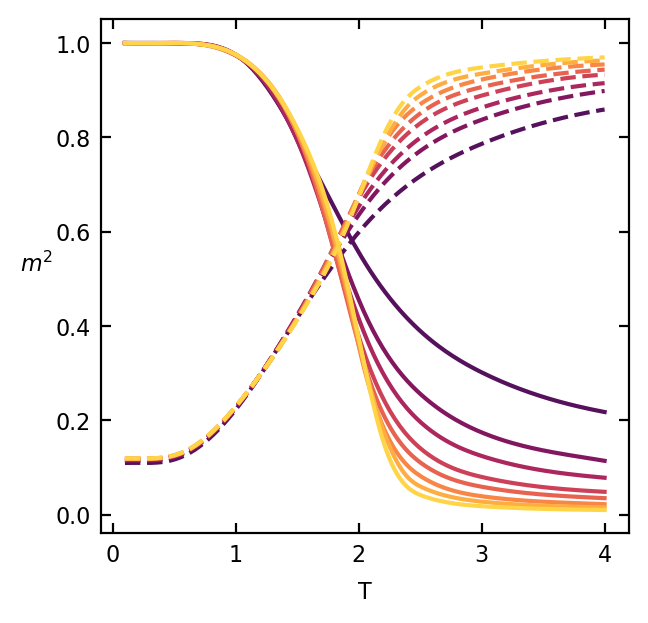

In [152]:
def orderparam(ax):
    with open(data_location / 'binder_data.pickle', 'rb') as file: 
        d = oBinder = Munch(pickle.load(file))
    
    with open(data_location / 'fermion_binder_data.pickle', 'rb') as file: 
        fermion = Munch(pickle.load(file))
    
    for i, N, c in zip(count(), d.Ns, colors):
        d.dM2[i] = np.maximum(d.dM2[i], d.dM2[i].mean() * 0.1)
        M_interped = UnivariateSpline(d.MX, d.M2[i], w = 1/(d.dM2[i] + 0.01*max(d.dM2[i])), s = len(d.MX))
        #axes[0].plot(d.MX, d.M2[i], linewidth = 1, color = c)
        #axes[0].errorbar(d.MX, d.M2[i], yerr = d.dM2[i] * 2, color = c, linestyle = "None", marker = '|', markersize = 0.5, label = f'N = {N}')

        x = np.linspace(d.MX[0], d.MX[-1], 200)
        
        ax.plot(x, M_interped(x), color = c)
        
        fermion.do[i] = np.maximum(fermion.do[i], fermion.do[i].mean() * 0.1)
        o_interped = UnivariateSpline(d.MX, fermion.o[i], w = 1/fermion.do[i], s = len(d.MX))
        ax.plot(x, 1 - o_interped(x), color = c,linestyle = '--')
        #spread(axes[0], d.MX, d.M2[i], d.dM2[i], alpha = 0.3, label = f'N = {N}', color = color)
        
        ax.set_ylabel('$m^2$', rotation=0, labelpad=7)
        ax.set_xlabel('T', rotation=0, labelpad=5)
    

        
f, ax = plt.subplots()
orderparam(ax)

In [153]:
np.insert([1,2,3], 0, 0)

array([0, 1, 2, 3])